# Overview

The research question we are interested in is **what is the political leaning of a particular domain?** 

The data we have are some existing data on the political leanings of a subset of domains of interest

Also, note that because the PEW data doesn't focus on domains but instead on news sources, I'm working here with correlation between a set of domains related to a particular news source. So, for instance, I'm lumping ```m.nytimes.com``` and ```nytimes.com``` into a single "news source" for this notebook. Obviously, that will have to be addressed too.

# Data Setup

In [16]:
from multiprocessing import Pool
from collections import Counter, defaultdict
from scipy.spatial.distance import pdist,squareform
from scipy.sparse.linalg import svds 
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances
from scipy import stats
import plotly.express as px
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import scale
sns.set(style="white")

## PEW Data

Data from this [PEW study](http://www.journalism.org/interactives/media-polarization/table/trust/). The PEW data I focused on was the question on what percentage of people who had a particular leaning got news from each of the different outlets.  There was also a trust question, these were pretty highly correlated.

In [17]:
pew_got_news = pd.read_csv("./pew_got_news_from.tsv",sep="\t")
pew_got_news.head()

,Source,Overall,Consistently liberal,Mostly liberal,Mixed,Mostly conservative,Consistently conservative
0,CNN,44,52,48,49,32,20
1,Fox News,39,10,24,39,61,84
2,ABC News,37,33,38,42,32,26
3,NBC News,37,37,44,40,29,21
4,CBS News,29,30,32,32,24,22


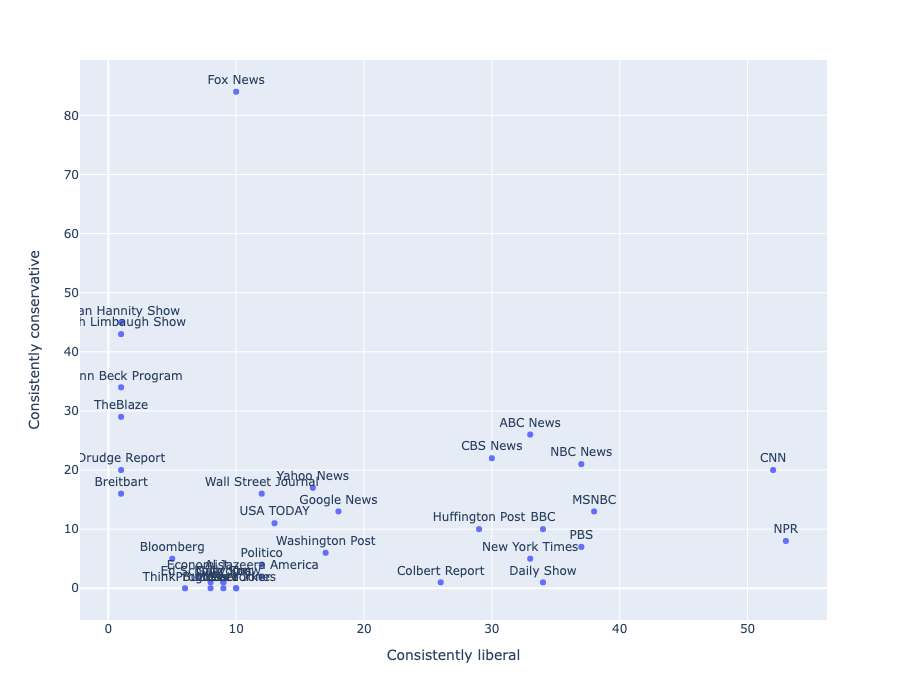

In [22]:
# fig, ax = plt.subplots()
# ax.scatter(pew_got_news['Consistently liberal'], pew_got_news['Consistently conservative'])
# m = [ax.annotate(x, (pew_got_news['Consistently liberal'][i],
#                      pew_got_news['Consistently conservative'][i])) for i,x in enumerate(pew_got_news.Source)]
# ax.set(ylabel="Percent Consistently Conservative who got news from outlet")
# ax.set(xlabel="Percent Consistently Liberal who got news from outlet")
# fig.set_size_inches((15,10))
fig = px.scatter(pew_got_news,'Consistently liberal','Consistently conservative',
           text='Source',
           height=700,width=700)
fig.update_traces(textposition='top center')

## Facebook data

The Facebook data I used is from [this study](http://science.sciencemag.org/content/348/6239/1130) and specifically the file ```top500.csv``` from their [replication material](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LDJ7MS).

In [24]:
# create a mapping from domain names and handles to organization name
news_org_info = pd.read_csv("pew_organization_to_twitter_handle.tsv",sep="\t")
web_to_org = {}
import numpy as np
for k, v in news_org_info.iterrows():
    for website in v['website'].split(","):
        web_to_org[website] = v['Name']

In [25]:
fb_cons_lib_scale = pd.read_csv("./top500.csv")
fb_cons_lib_scale.head()

,domain,avg_align,l2,l1,n,r1,r2
0,6abc.com,-0.5037,0.0925,0.4060,0.4659,0.0349,0.0007
1,7online.com,-0.4067,0.0751,0.2747,0.6391,0.0093,0.0018
2,800whistleblower.com,0.8268,0.0002,0.0003,0.0038,0.5081,0.4876
3,aattp.org,-0.8936,0.9486,0.0509,0.0004,0.0001,0.0000
4,abc11.com,-0.1900,0.0740,0.3381,0.4908,0.0926,0.0045


In [26]:
# map domain names to 
fb_cons_lib_scale['Source'] = fb_cons_lib_scale.apply(lambda x: web_to_org.get(x['domain'],""),axis=1)
fb_cons_lib_scale = fb_cons_lib_scale[fb_cons_lib_scale.Source != ""].groupby("Source").avg_align.mean().reset_index()

# Analysis

I first ruled out a bunch of these domains for one of three reasons:
- Its not a show anymore (Colbert, Ed Schultz)
- It doesn't have a unique domain (Colbert and Daily Show both resolve to cc.com as the top-level domain)
- It really wasn't in our data (PBS, Glenn Beck)
- It wasn't also in the Facebook data I'll use below (the rest)

Our results actually improve if we don't use the last two filters, because they rule out a lot of the conservative sites. So we could revisit, but this was the easiest and most restrictive way to do it for now

In [27]:
IRRELEVANT_DOMAINS = ["Ed Schultz Show","PBS","Colbert Report","Daily Show",'Drudge Report', 
                      'Google News', 'NBC News', 'Sean Hannity Show',"Glenn Beck Program",
                      "Rush Limbaugh Show","NBC News"]

For the PEW data, we're going to define "similarity in political leaning" as the cosine similarity in a vector of five values for each news agency:

- %age of Consistently liberals who got news from site
- %age of Mostly liberal who got news from site
- %age of Mixed	who got news from site
- %age of Mostly conservative who got news from site
- %age of Consistently conservative who got news from site

This means that things that are trusted by everyone a lot (e.g. to a certain extent ABC News) will be rated as being **fairly different** from things that are trusted by everyone a little (e.g. BuzzFeed). 


For the Facebook data, we're just going to focus on average political leaning as they define it [-2,2] interval. This means that things that are trusted by everyone a lot will be rated as being **fairly similar to** things that are trusted by everyone a little.  As we'll see, its not going to matter anyway.

Below are the similarity matrices for the PEW data...


<Figure size 504x504 with 0 Axes>

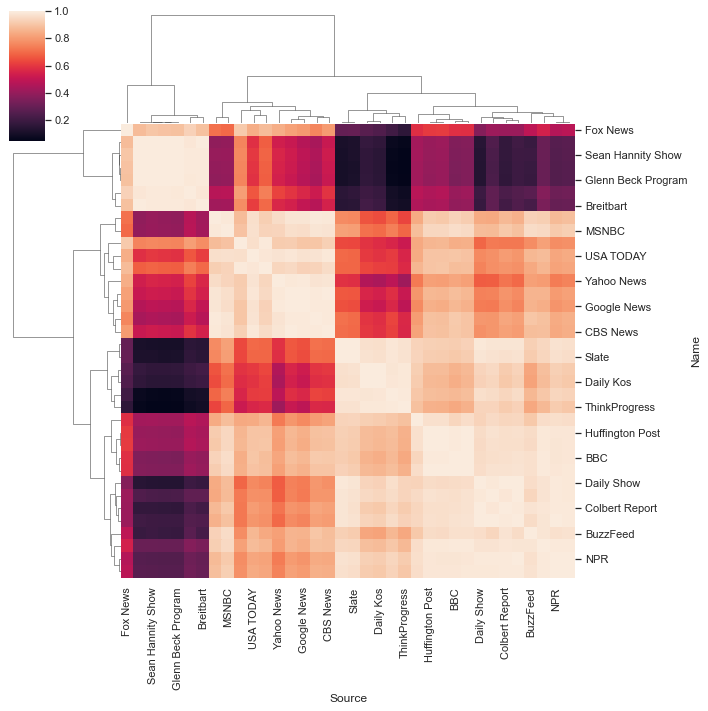

In [28]:
# PEW DATA
pew_mat = pd.DataFrame(cosine_similarity(pew_got_news.iloc[:,1:].values),
                       columns=pew_got_news.Source)
pew_mat['Name'] = pew_mat.columns

plt.figure(figsize=(7, 7))
g = sns.clustermap(pew_mat.set_index("Name"))
x = plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

... and the FB data

<Figure size 504x504 with 0 Axes>

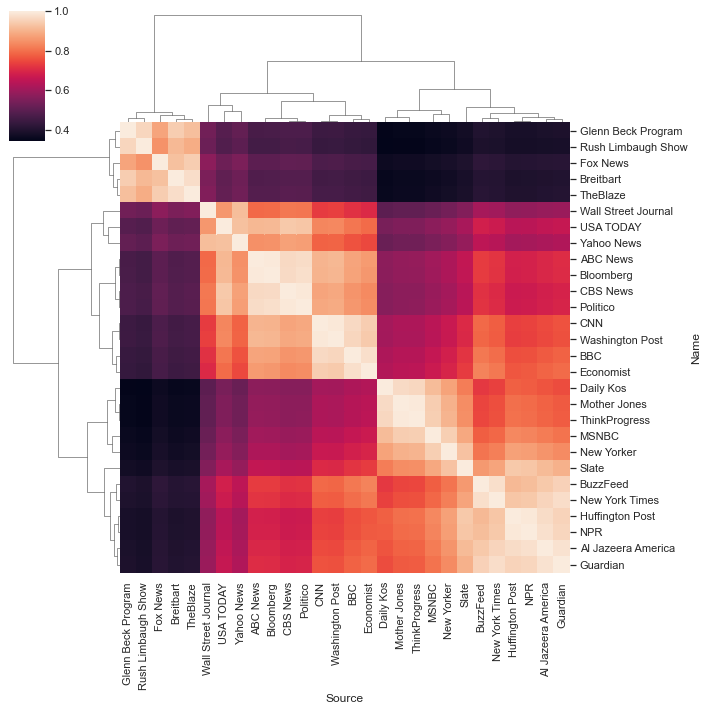

In [13]:
# FB Data
fb_mat = pd.DataFrame(1./(1+manhattan_distances(fb_cons_lib_scale.iloc[:,1:].values)),
                          columns=fb_cons_lib_scale.Source)
fb_mat['Name'] = fb_mat.columns

plt.figure(figsize=(7, 7))
g = sns.clustermap(fb_mat.set_index("Name"))
x = plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)


In [33]:
from sklearn.cluster import AgglomerativeClustering

cluster_model = AgglomerativeClustering(n_clusters= None,
                                        compute_full_tree=True,
                                        compute_distances=True,
                                        distance_threshold=0).fit(fb_cons_lib_scale.iloc[:,1:].values)
cluster_model.labels_

array([27, 22, 21, 17, 19, 20, 24, 25, 18, 13, 26,  8, 10, 23, 14, 12, 15,
       16,  7,  6, 11,  9,  4,  3,  5,  1,  2,  0])

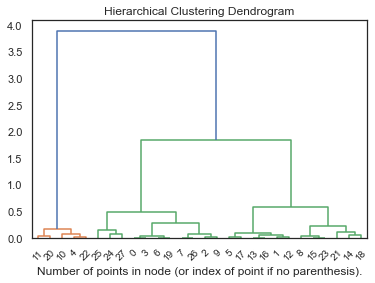

In [39]:
from scipy.cluster.hierarchy import dendrogram
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(cluster_model, truncate_mode="level", p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [41]:
fb_cons_lib_scale.Source.iloc[[11,20,10,4]]

11    Glenn Beck Program
20    Rush Limbaugh Show
10              Fox News
4              Breitbart
Name: Source, dtype: object